# Generating Deep Neural Network Model Explanations via ChemML's Explain Module

### The `chemml.explain` module has three eXplainable AI (XAI) methods - DeepSHAP, LRP, and LIME. It allows both local (for a single instance) and global (aggregated for multiple instances) explanations. The explainations are in the form of a relevance score attributed to each feature used to build the DNN model.

We use a sample dataset from ChemML library which has the SMILES codes and 200 Dragon molecular descriptors (features) for 500 small organic molecules with their densities in $kg/m^3$. We split the dataset into training and testing subsets and scale them. We then build and train a pytorch DNN on the training subset.

In [1]:
import pandas as pd
import shap
from chemml.models import MLP
from chemml.datasets import load_organic_density

from sklearn.preprocessing import StandardScaler
from chemml.explain import Explain

_, y, X = load_organic_density()
columns = list(X.columns)

y = y.values.reshape(y.shape[0], 1).astype('float32')
X = X.values.reshape(X.shape[0], X.shape[1]).astype('float32')

# split 0.9 train / 0.1 test
ytr = y[:450, :]
yte = y[450:, :]
Xtr = X[:450, :]
Xte = X[450:, :]

scale = StandardScaler()
scale_y = StandardScaler()
Xtr = scale.fit_transform(Xtr)
Xte = scale.transform(Xte)
ytr = scale_y.fit_transform(ytr)

# PYTORCH
r1_pytorch = MLP(engine='pytorch',nfeatures=Xtr.shape[1], nneurons=[100,100,100], activations=['ReLU','ReLU','ReLU'],
        learning_rate=0.001, alpha=0.0001, nepochs=100, batch_size=100, loss='mean_squared_error', 
        is_regression=True, nclasses=None, layer_config_file=None, opt_config='Adam')

r1_pytorch.fit(Xtr, ytr)
engine_model = r1_pytorch.get_model()
engine_model.eval()

Sequential(
  (0): Linear(in_features=200, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=1, bias=True)
)

### DeepSHAP Explanations

We instantiate the `chemml.explain` object with an instance to be explained, the pytorch DNN object, and the feature names (columns). We then call the DeepSHAP method with a set of background or reference samples as directed by the [SHAP library](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html).

In [2]:
X_instance = Xtr[0]
exp = Explain(X_instance = X_instance, dnn_obj = engine_model, feature_names = columns)

explanation, shap_obj = exp.DeepSHAP(X_background = Xtr[1:10])

explanation

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,X4Av,X5Av,X0sol,X1sol,X2sol,X3sol,X4sol,X5sol,XMOD,RDCHI
0,0.031939,-0.05199,-0.006925,-0.006857,0.027388,-0.020872,-0.057089,-0.115971,-0.00581,-0.000805,...,-0.087464,-0.240233,0.002718,0.003733,0.008075,0.011319,0.007988,-0.000032,0.01838,0.002904


### Visualizing local DeepSHAP explanations using a waterfall plot adapted from the shap library.

c:\users\nitin\documents\ub\hachmann_group\chemml_dev_nitin\chemml\chemml\explain\visualize.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = shap_values[order[i]]
c:\users\nitin\documents\ub\hachmann_group\chemml_dev_nitin\chemml\chemml\explain\visualize.py:148: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yticklabels[rng[i]] = _format_value(features[order[i]], "%0.03f") + " = " + feature_names[order[i]]


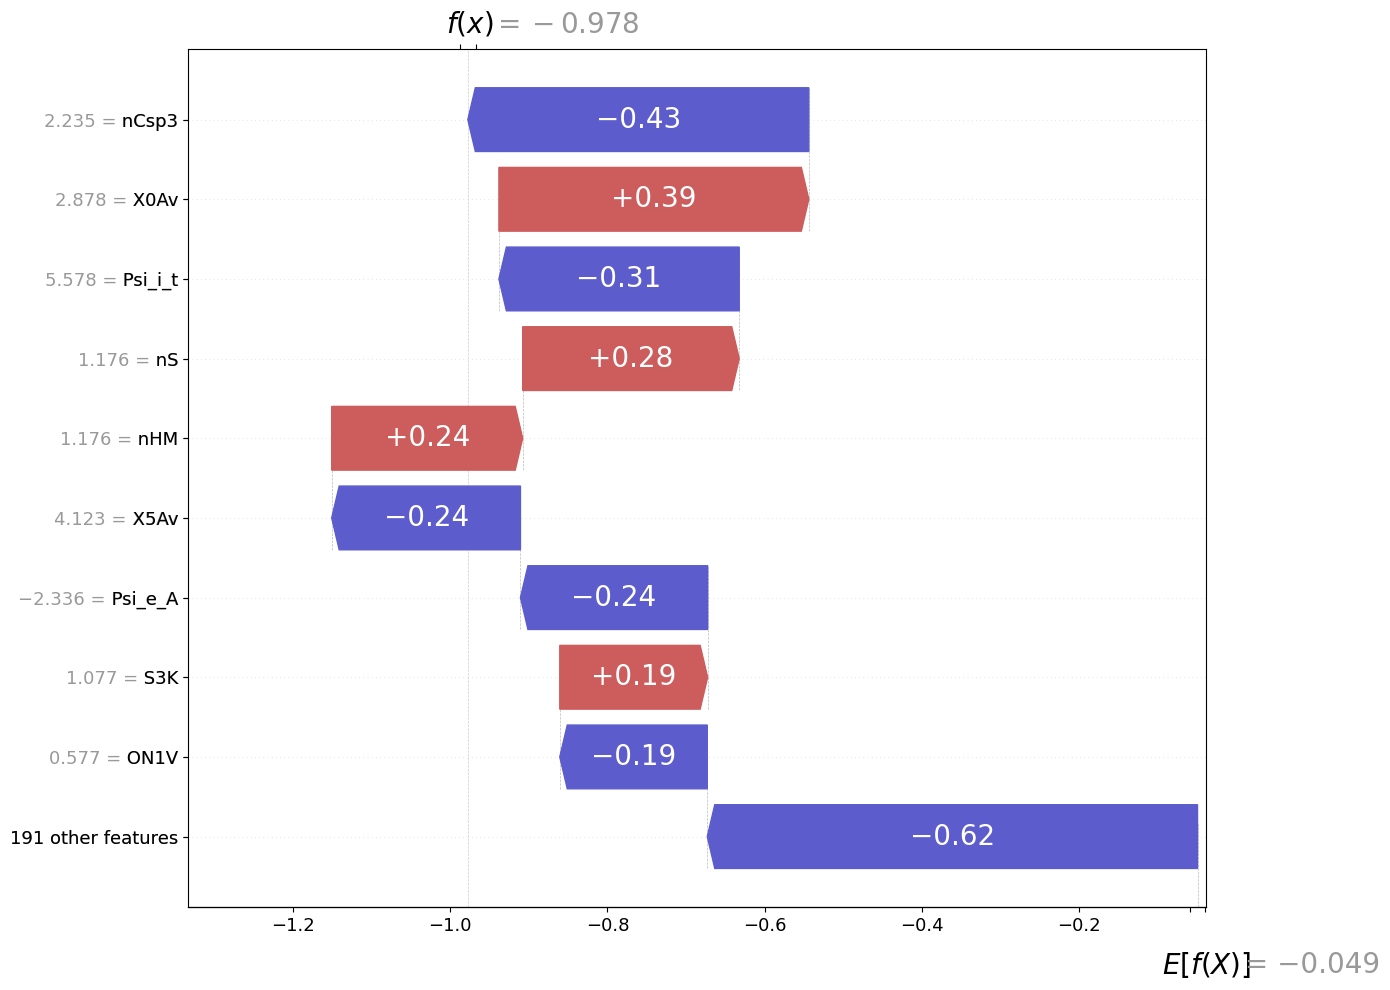

In [3]:
fig = exp.plot(local=True, rel_df=explanation,max_display=10, shap_obj=shap_obj)

In [4]:
X_instance = Xtr
exp = Explain(X_instance = X_instance, dnn_obj = engine_model, feature_names = columns)

explanation, shap_obj = exp.DeepSHAP(X_background = Xtr[1:10])

explanation

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,X4Av,X5Av,X0sol,X1sol,X2sol,X3sol,X4sol,X5sol,XMOD,RDCHI
0,0.031939,-0.051990,-0.006925,-0.006857,0.027388,-0.020872,-0.057089,-0.115971,-0.005810,-0.000805,...,-0.087464,-0.240233,0.002718,0.003733,0.008075,0.011319,0.007988,-0.000032,0.018380,0.002904
1,-0.030329,0.045286,0.003471,0.009392,-0.033369,0.005686,0.015329,0.132120,-0.011706,0.006712,...,0.013431,0.027834,0.004760,-0.020271,-0.006235,-0.019104,-0.005018,-0.010347,-0.040244,-0.002089
2,0.073318,-0.011014,-0.010239,-0.012253,0.034129,-0.015133,-0.017885,0.005359,-0.016987,0.026442,...,0.006582,0.013818,-0.008897,0.031285,0.015545,0.022423,0.014267,-0.002429,0.078428,-0.039955
3,-0.051775,0.060634,0.028966,0.011126,-0.046096,0.022779,-0.021990,0.079879,-0.005687,-0.001833,...,-0.055763,-0.149791,0.011571,-0.056075,-0.012510,-0.014471,-0.010389,-0.003207,-0.077971,0.076956
4,0.078189,0.049846,-0.006229,-0.007896,0.024672,-0.011916,-0.001073,0.035578,-0.000805,0.019776,...,0.003993,0.007286,-0.010335,0.039825,0.012199,0.021159,0.010633,0.004272,0.090355,-0.020396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.008847,0.394204,0.027389,0.021292,-0.046195,0.024054,0.122414,0.310809,0.111767,0.002920,...,0.001368,0.002888,0.011813,-0.006262,-0.004366,0.002759,0.004123,-0.014602,0.027206,0.010870
446,0.064879,0.029331,-0.023800,-0.014171,0.023401,-0.014327,0.026467,-0.096276,0.037964,-0.028652,...,0.000230,0.005973,0.003281,0.038597,0.030991,0.038983,0.024876,0.010109,0.078109,-0.032479
447,0.086556,-0.004422,-0.007464,-0.019316,0.037914,-0.011631,-0.008085,0.005726,-0.011518,0.041259,...,0.008781,0.014713,-0.020406,0.043650,0.018309,0.026390,0.009535,0.016264,0.104574,-0.033671
448,0.090357,0.031684,-0.036333,-0.023286,0.013101,-0.025404,0.024115,-0.069291,0.041967,-0.028402,...,0.004694,0.006852,0.001424,0.085513,0.071626,0.091616,0.028419,0.041313,0.184755,-0.036952


c:\users\nitin\documents\ub\hachmann_group\chemml_dev_nitin\chemml\chemml\explain\visualize.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(shaps[nan_mask], pos + ys[nan_mask], color="#5c5ccd", vmin=vmin, vmax=vmax, s=16, alpha=1, linewidth=0, zorder=3) #, rasterized=len(shaps)>500)


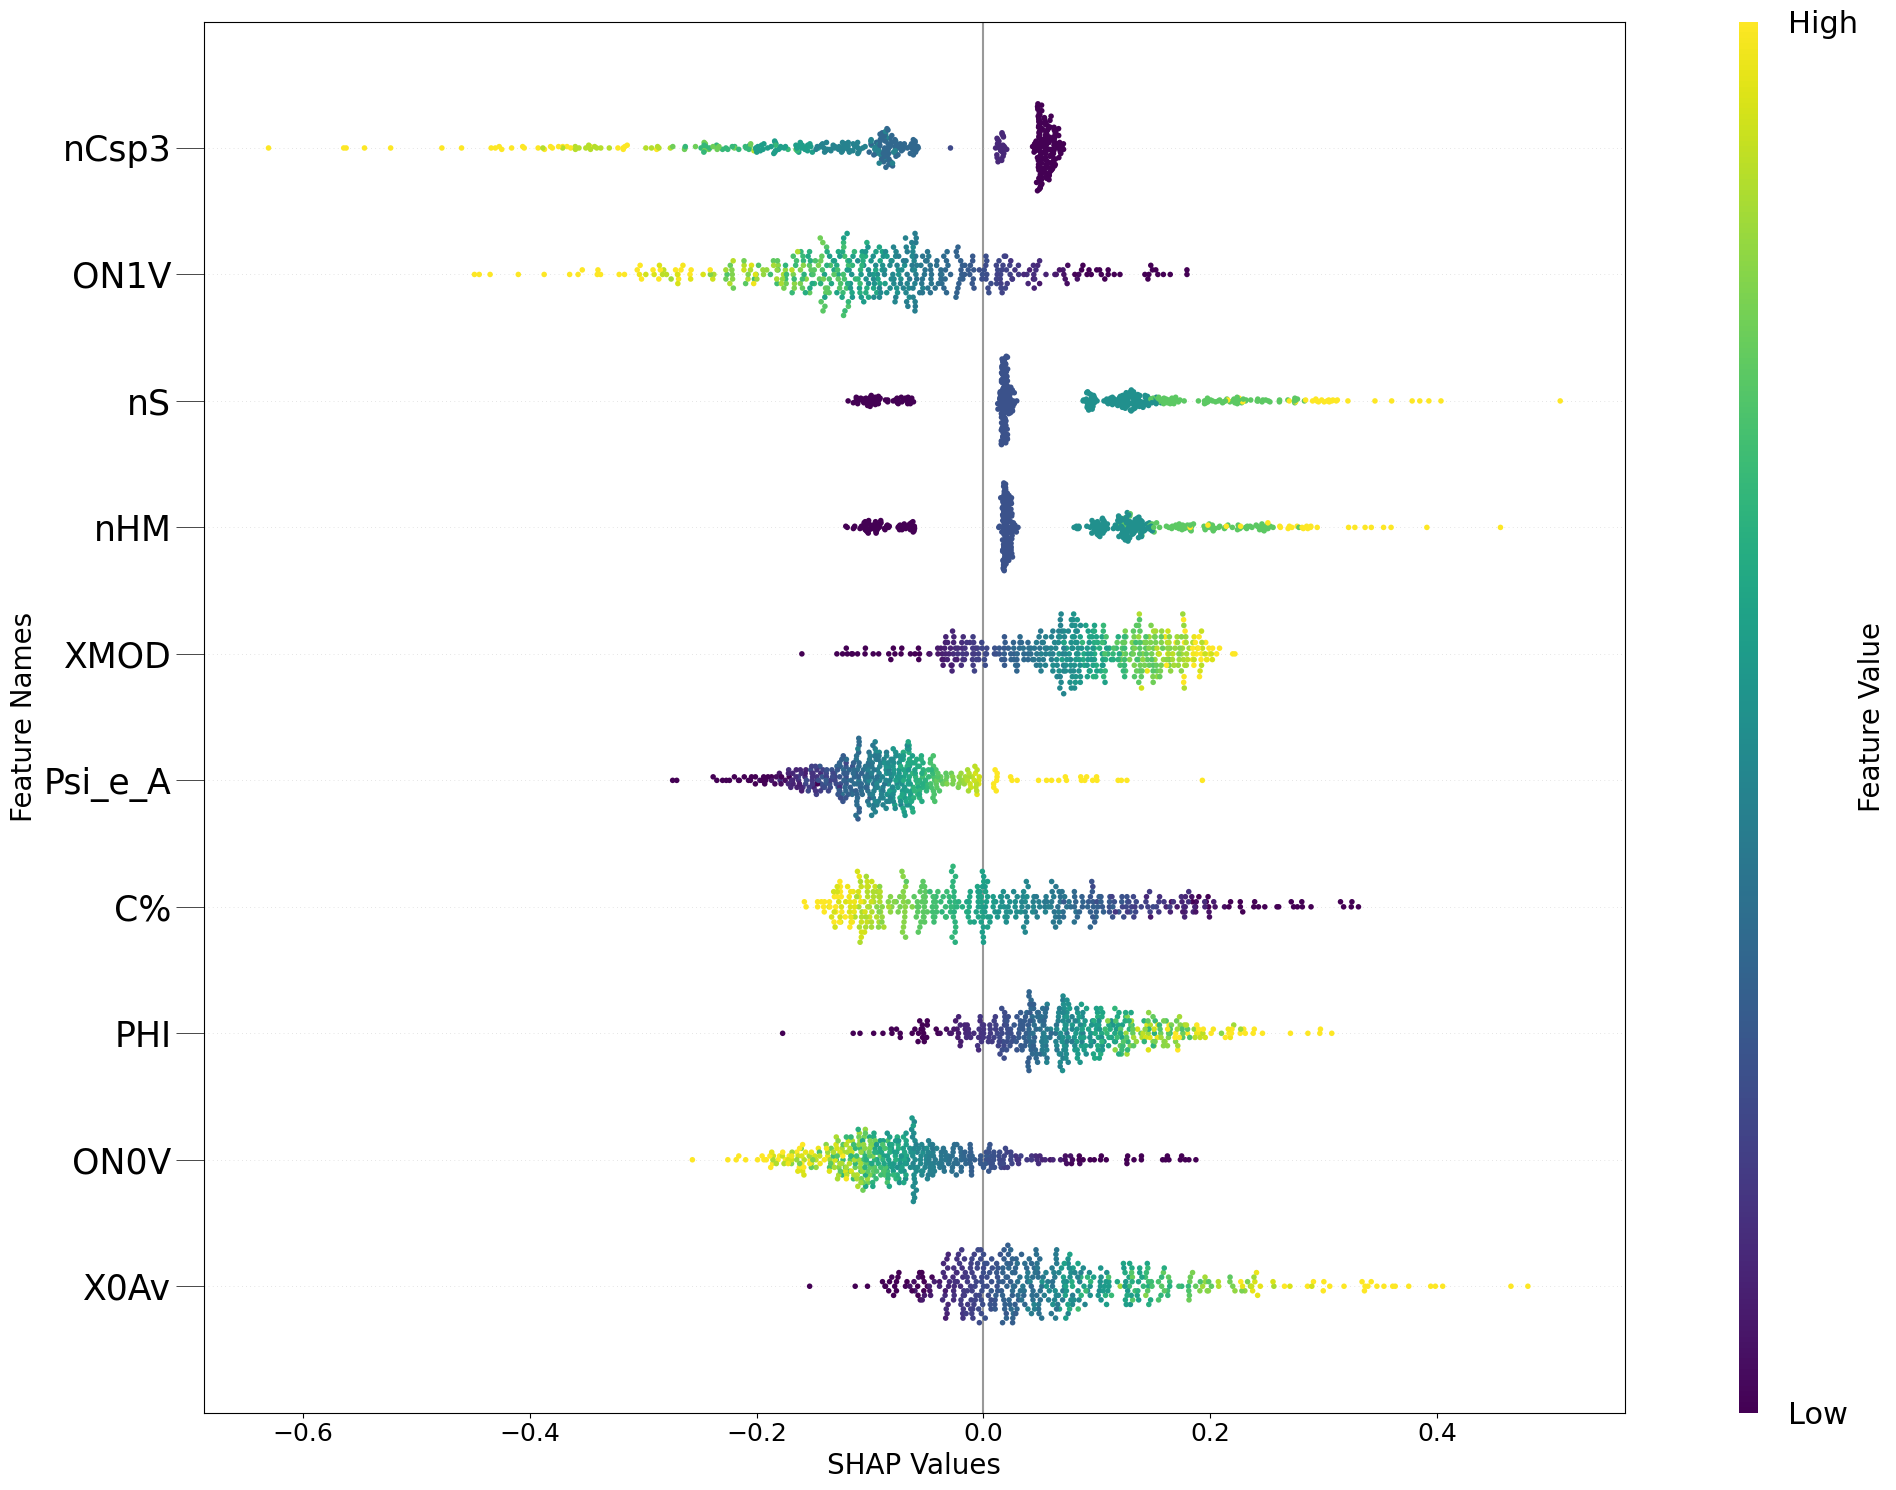

In [5]:
fig = exp.plot(local=False, rel_df=explanation,max_display=10, shap_obj=shap_obj)

In [6]:
X_instance = Xtr[0]
exp = Explain(X_instance = X_instance, dnn_obj = engine_model, feature_names = columns)

explanation, gb = exp.LRP(strategy='zero', global_relevance=False)

explanation

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,X4Av,X5Av,X0sol,X1sol,X2sol,X3sol,X4sol,X5sol,XMOD,RDCHI
0,0.0357,0.060859,-0.030067,-0.000306,0.011614,-0.00287,0.038521,0.075271,0.012589,-0.001871,...,0.087779,0.240536,-0.009204,0.0284,0.03282,0.028609,0.015671,-0.003383,0.059679,-0.03687


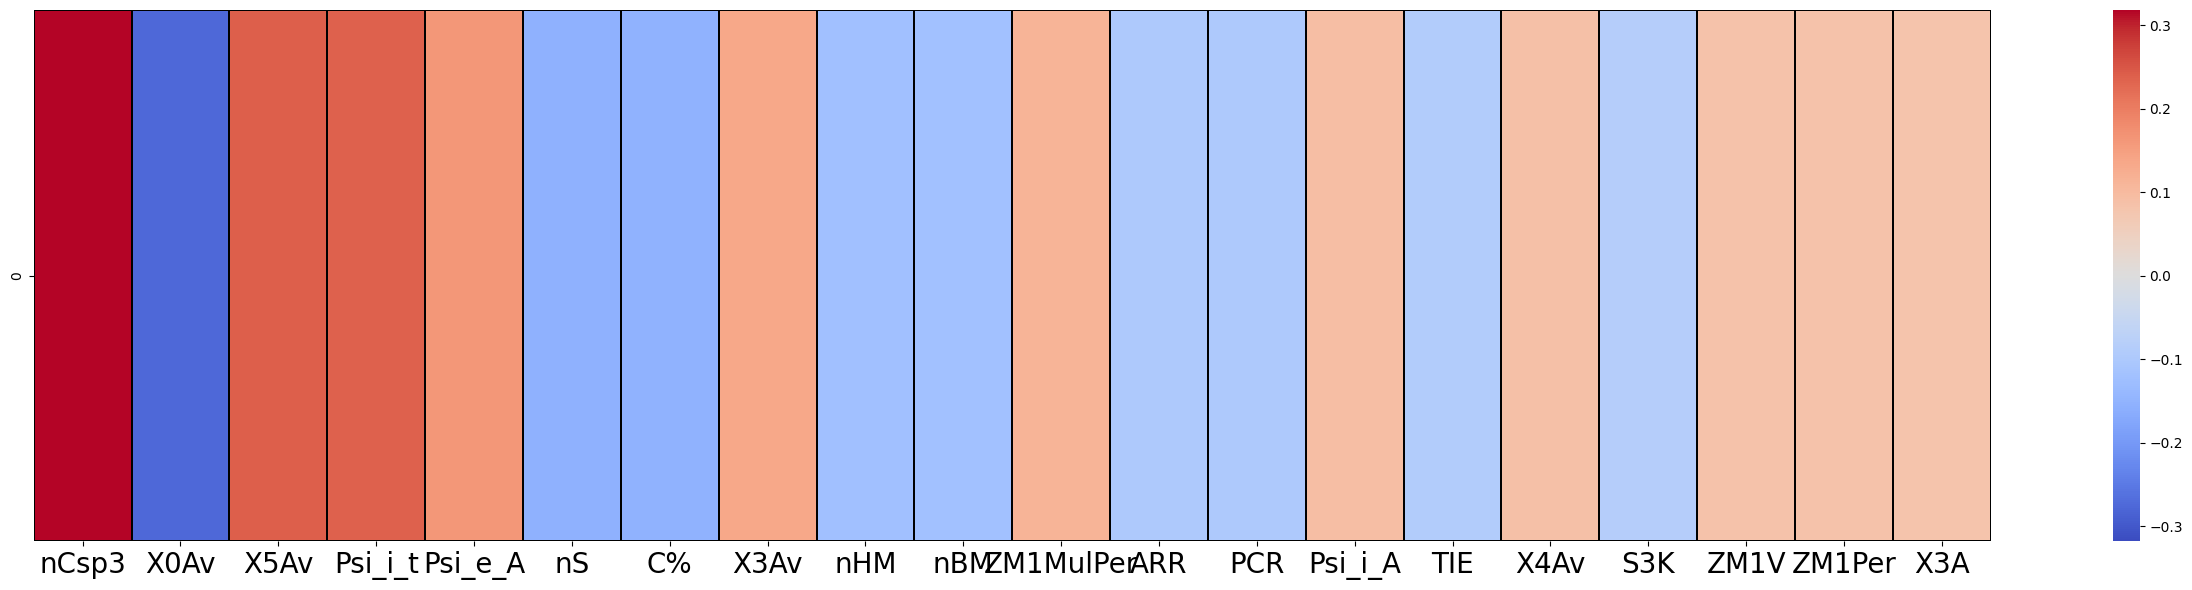

In [7]:
f = exp.plot(local=True,rel_df = explanation, max_display=20)

In [8]:
# strategies + global relevance
X_instance = Xte

exp = Explain(X_instance = X_instance, dnn_obj = engine_model, feature_names = columns)

explanation, gb = exp.LRP(strategy='zero', global_relevance=True)
explanation.head()

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,X4Av,X5Av,X0sol,X1sol,X2sol,X3sol,X4sol,X5sol,XMOD,RDCHI
0,-0.002375,-0.002310,0.003538,0.000393,0.002531,0.000539,-0.003484,0.005217,-0.006279,0.010001,...,-0.000975,0.000208,-0.000257,-0.006816,-0.006439,-0.011138,0.000251,-0.004060,-0.012186,0.000308
1,0.031408,0.003845,-0.003586,-0.000377,0.027020,-0.001780,-0.002846,-0.015842,-0.002071,-0.001520,...,-0.003107,-0.015789,-0.003154,0.009662,0.004628,0.018693,0.008019,0.004508,0.030692,-0.002962
2,-0.003544,0.010888,0.010702,0.010161,0.009560,0.011691,-0.010409,0.024565,-0.007086,0.010840,...,-0.008347,-0.008716,-0.009222,-0.013408,-0.038706,-0.029874,-0.009861,-0.006868,-0.024265,0.010711
3,0.336607,0.222507,-0.021707,0.050956,0.121637,-0.015981,0.095192,0.031510,0.073009,-0.109299,...,-0.013377,-0.021679,-0.057243,0.103574,-0.009558,0.117196,0.026707,0.029786,0.304746,-0.031534
4,-0.008907,-0.007431,0.001667,0.000218,-0.007712,0.000166,-0.007769,0.010181,-0.007833,0.010821,...,0.004072,0.007154,0.001378,-0.005021,-0.004586,-0.005019,-0.004799,-0.008497,-0.007774,-0.002996


In [9]:
gb

,Mean Absolute Relevance Score,Mean Relevance Score
nHet,0.083375,0.080595
ON1V,0.082356,0.054230
nS,0.082029,0.073870
nHM,0.081260,0.072965
nCsp3,0.081243,0.026852
...,...,...
SRW10,0.004217,0.000566
MWC01,0.004144,0.001311
Psi_i_0d,0.003676,-0.003646
LPRS,0.002950,0.000132


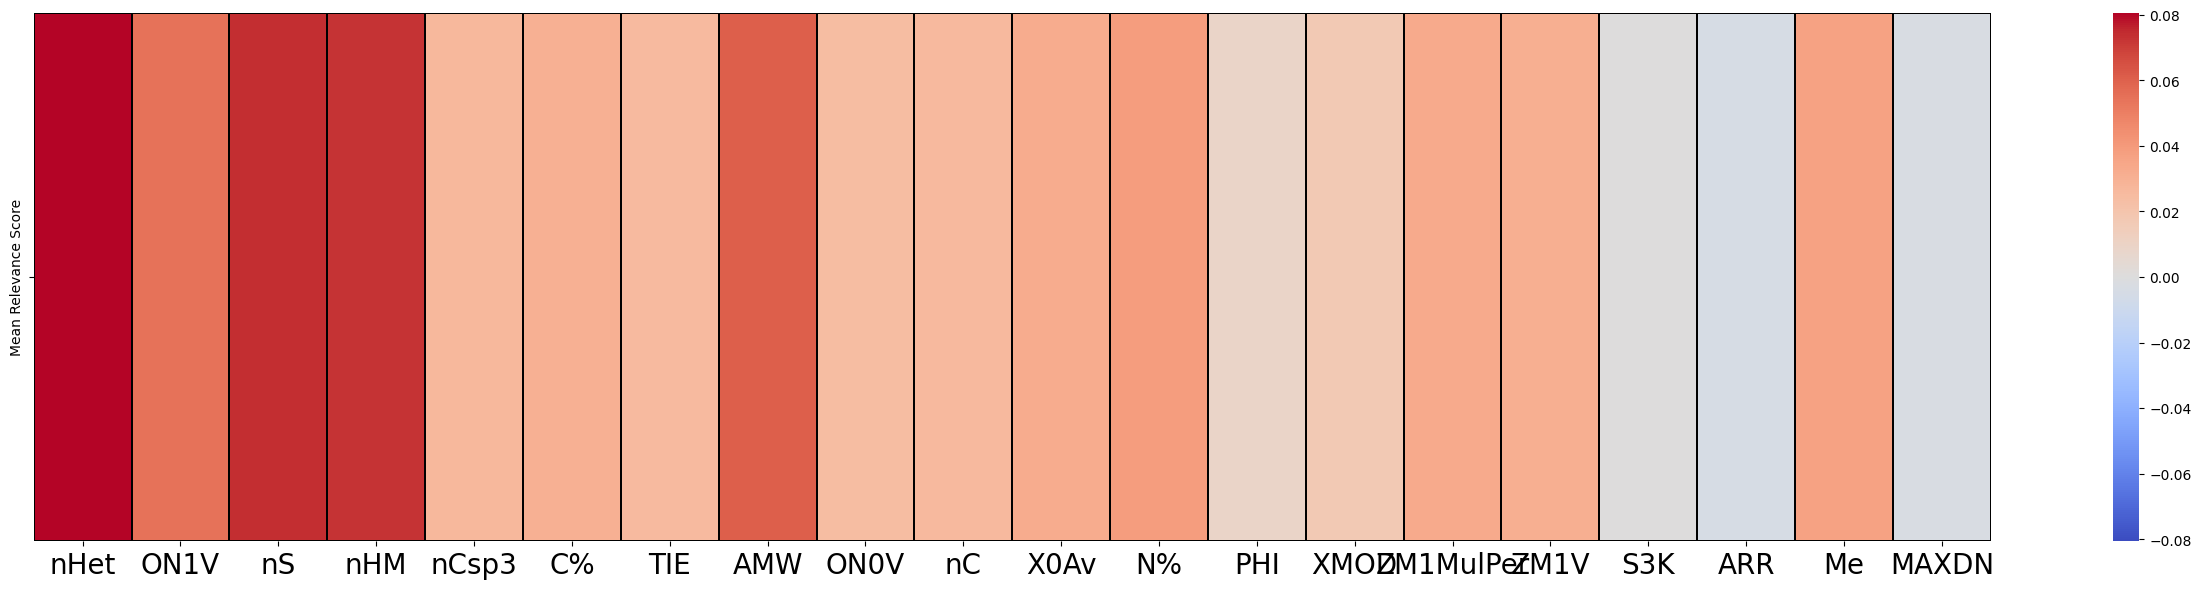

In [10]:
f = exp.plot(local=False,rel_df = gb, max_display=20)

In [11]:
X_instance = Xte[0:3]
exp = Explain(X_instance = X_instance, dnn_obj = engine_model, feature_names = columns)
explanation = exp.LIME(training_data=Xtr)
print(explanation)

Intercept 0.11532020646501222
Prediction_local [-0.25389418]
Right: -0.18441454
Intercept 0.22570137102586968
Prediction_local [0.09135068]
Right: -0.35446894
Intercept 0.30997393583284116
Prediction_local [-0.77875192]
Right: -0.5938779
[                   labels  local_relevance
0               C% > 0.87        -0.178290
1       Psi_i_1d <= -0.01         0.154477
2           nHet <= -0.60        -0.136784
3               nC > 0.73        -0.133803
4             N% <= -0.73        -0.088682
..                    ...              ...
195     0.05 < Xu <= 0.86         0.000874
196  0.06 < X1sol <= 0.88        -0.000847
197          X0A <= -0.68        -0.000638
198     0.03 < Sp <= 0.79        -0.000621
199         piPC10 > 0.86        -0.000148

[200 rows x 2 columns],                      labels  local_relevance
0               nS <= -0.60        -0.188840
1             ON1V <= -0.62         0.184538
2              TIE <= -0.66         0.171063
3              nHM <= -0.60        -0.15

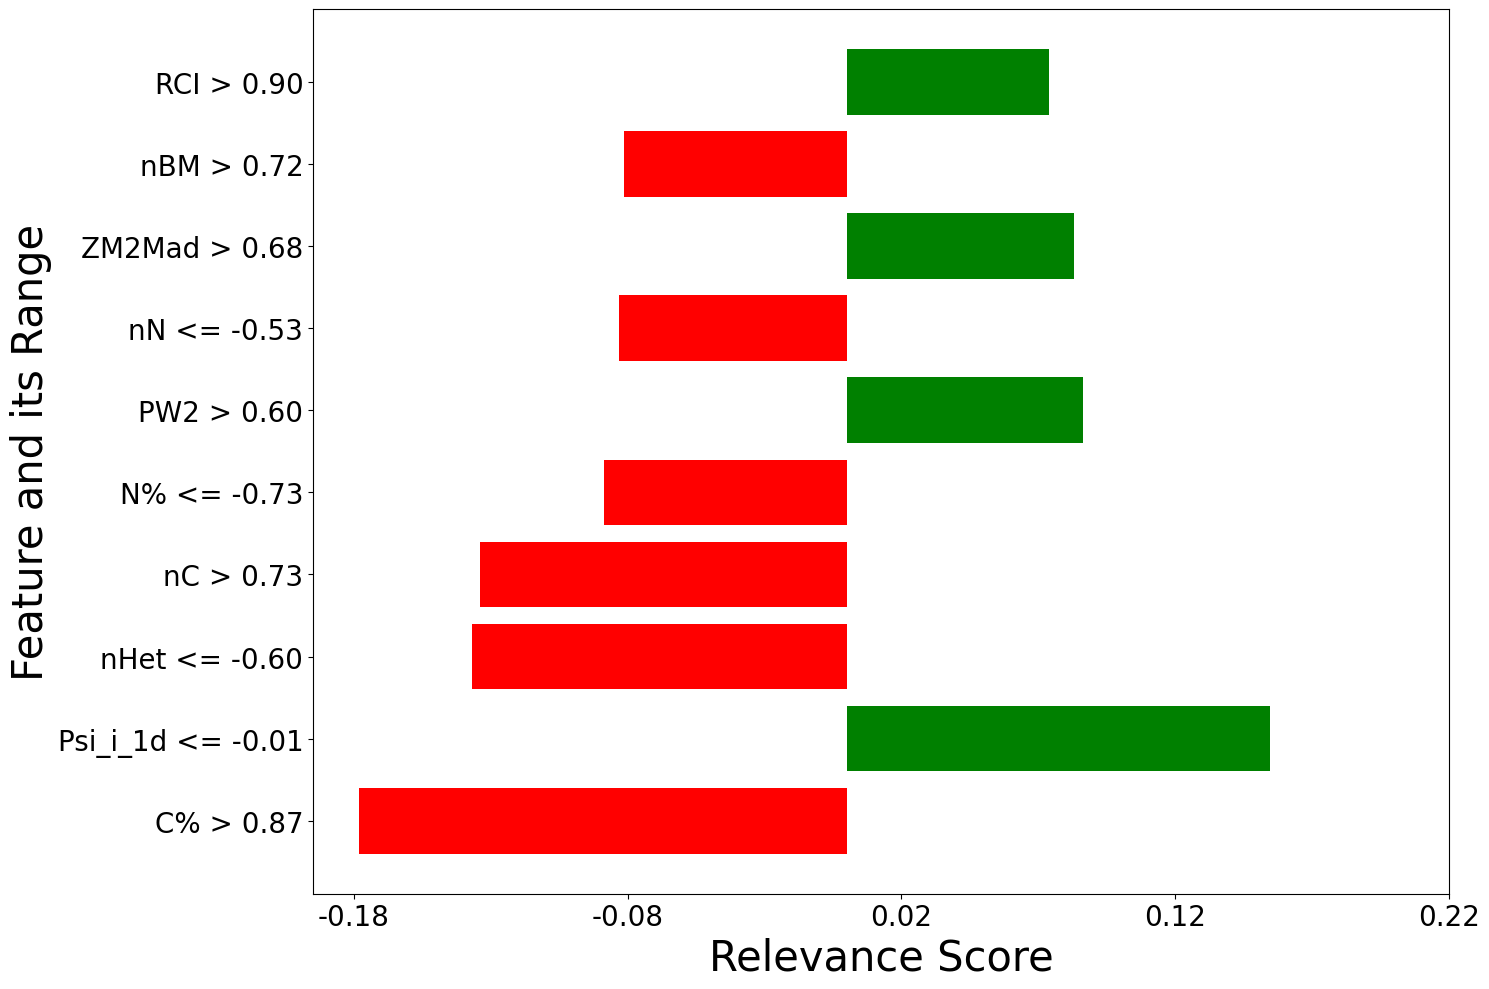

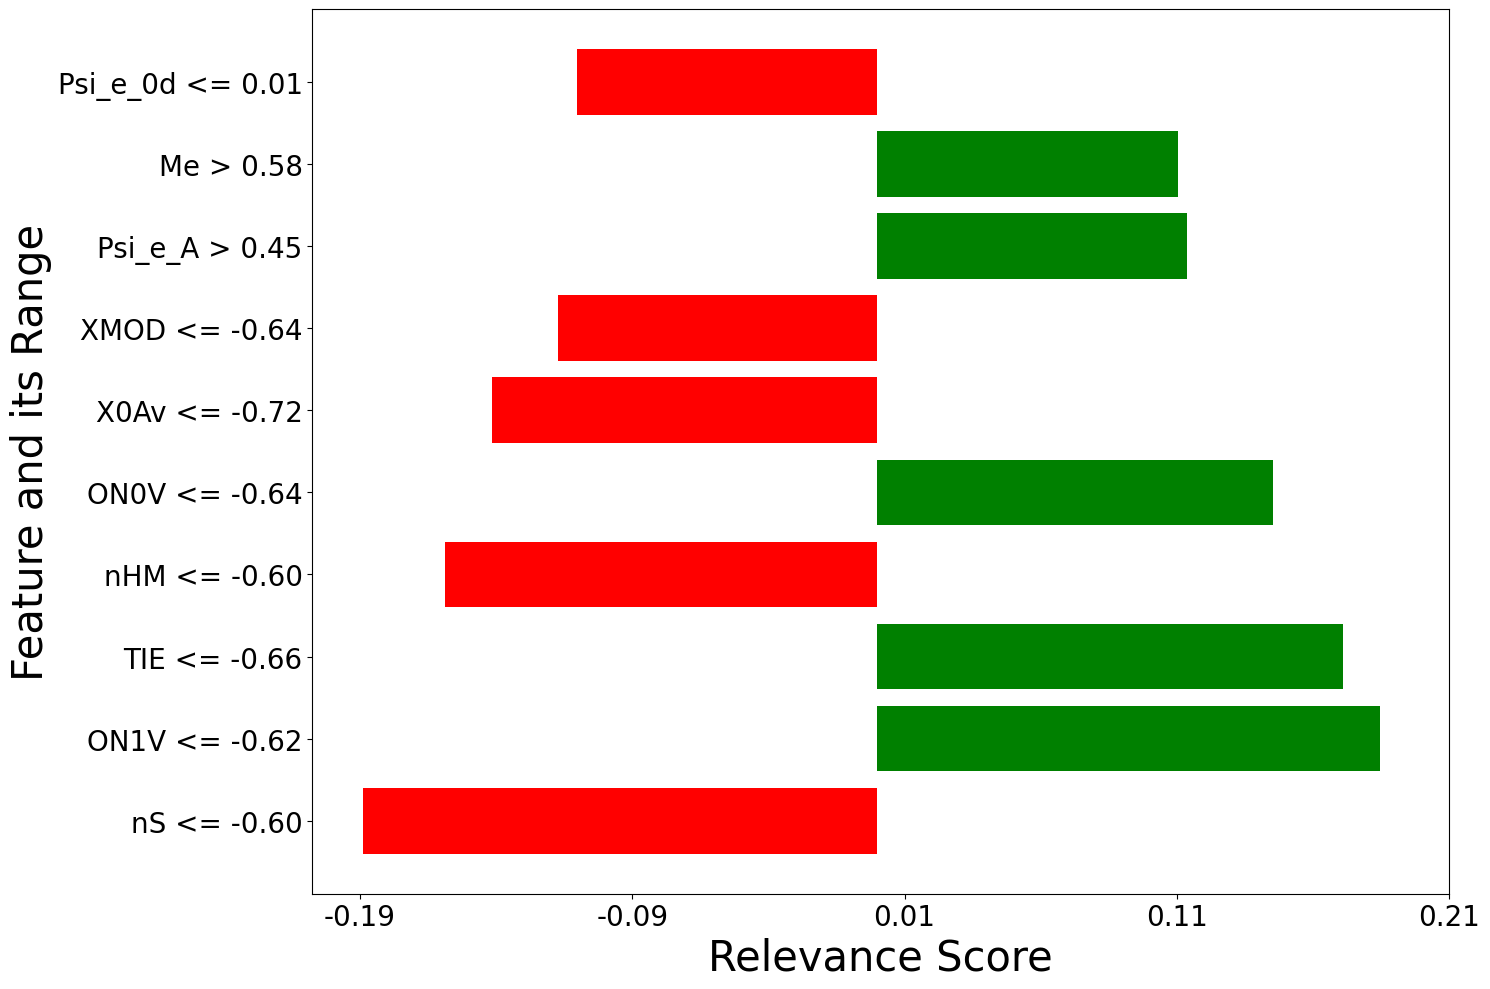

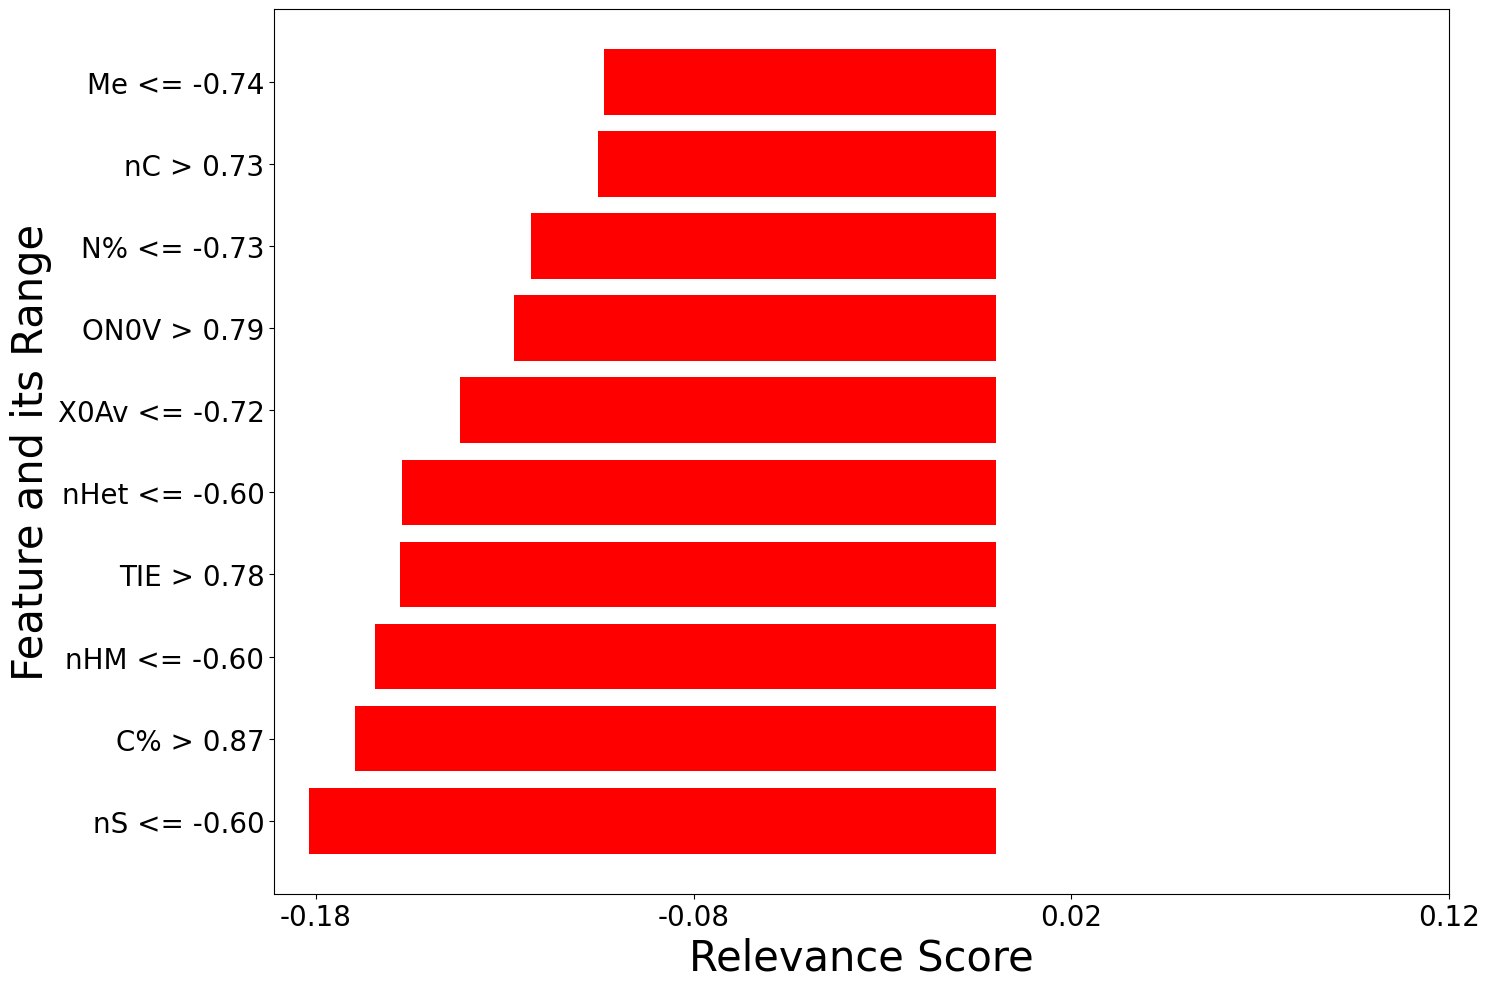

In [12]:
f=[]
for local_explanation in explanation:
    f.append(exp.plot(local=True, rel_df = local_explanation, max_display=10))